# LDA Klasifikasi Berita

In [2]:
## SETUP

# Import library dasar
import pandas as pd
import numpy as np
import time

# Import untuk LDA & Koherensi
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, HdpModel

# Import untuk Klasifikasi & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Import untuk Visualisasi
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from matplotlib.lines import Line2D
import umap

print("Semua library berhasil diimpor.")



Semua library berhasil diimpor.


In [3]:
# Memuat Dataset 
try:
    df = pd.read_csv('hasil_preprocessing_beritaUTS.csv')
    print(f"\nDataset berhasil dimuat. Jumlah data: {len(df)} baris.")
    print("Contoh data awal:")
    print(df.head())
except FileNotFoundError:
    print("\nError: File tidak ditemukan. Pastikan nama file CSV sudah benar.")
    # Jika file tidak ditemukan, hentikan proses.
    # df = pd.DataFrame()


Dataset berhasil dimuat. Jumlah data: 1500 baris.
Contoh data awal:
                                              berita  \
0  Menteri Koordinator (Menko) Bidang Perekonomia...   
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...   
2  Wacana Presiden Prabowo Subianto akan membentu...   
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...   
4  Pemerintah akan segera membentuk Satuan Tugas ...   

                                 hasil_preprocessing kategori  
0  ['menteri', 'koordinator', 'menko', 'bidang', ...  Ekonomi  
1  ['rangka', 'memeriahkan', 'pt', 'surabaya', 'i...  Ekonomi  
2  ['wacana', 'presiden', 'prabowo', 'subianto', ...  Ekonomi  
3  ['bpjs', 'ketenagakerjaan', 'kementerian', 'ag...  Ekonomi  
4  ['pemerintah', 'membentuk', 'satuan', 'tugas',...  Ekonomi  



Kamus dibuat dan difilter. Jumlah kata unik: 2509

--- Menjalankan HDP untuk estimasi jumlah topik... ---
✅ HDP mengestimasi ada sekitar: 20 topik.

--- Menjalankan pencarian koherensi dari 5 hingga 40 topik... ---
Selesai menghitung untuk 5 topik. Skor Koherensi: 0.6568
Selesai menghitung untuk 10 topik. Skor Koherensi: 0.5083
Selesai menghitung untuk 15 topik. Skor Koherensi: 0.5970
Selesai menghitung untuk 20 topik. Skor Koherensi: 0.5935
Selesai menghitung untuk 25 topik. Skor Koherensi: 0.5969
Selesai menghitung untuk 30 topik. Skor Koherensi: 0.6130
Selesai menghitung untuk 35 topik. Skor Koherensi: 0.6028

Total waktu pencarian koherensi: 8.16 menit


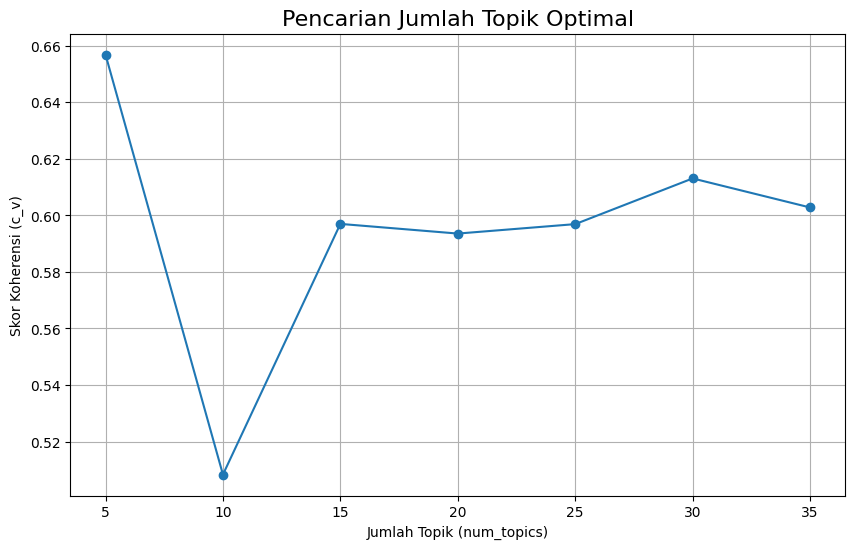


✅ Jumlah topik optimal yang ditemukan: 5

--- Melatih model LDA final dengan topik optimal... ---

--- Topik-topik yang Ditemukan oleh Model LDA ---
Topik: 0
Kata-kata: 0.017*"'rp'," + 0.016*"'persen'," + 0.011*"'prabowo'," + 0.011*"'program'," + 0.010*"'indonesia'," + 0.009*"'pemerintah'," + 0.009*"'jakarta'," + 0.007*"'ppn'," + 0.007*"'juta'," + 0.007*"'presiden'," + 0.007*"'masyarakat'," + 0.007*"'makan'," + 0.006*"'harga'," + 0.005*"'pajak'," + 0.005*"'bergizi',"

Topik: 1
Kata-kata: 0.017*"'korban'," + 0.014*"'kebakaran'," + 0.013*"'orang'," + 0.010*"'warga'," + 0.009*"'air'," + 0.009*"'rumah'," + 0.009*"'banjir'," + 0.008*"'pesawat'," + 0.008*"'los'," + 0.008*"'angeles'," + 0.007*"'jalan'," + 0.007*"'kota'," + 0.007*"'api'," + 0.007*"'wilayah'," + 0.006*"'mobil',"

Topik: 2
Kata-kata: 0.029*"'indonesia'," + 0.019*"'timnas'," + 0.017*"'pemain'," + 0.016*"'piala'," + 0.012*"'gol'," + 0.012*"'menit'," + 0.010*"'laga'," + 0.010*"'pelatih'," + 0.010*"'liga'," + 0.009*"'tim'," + 0.009

In [4]:
## EKSTRAKSI FITUR LDA & PENCARIAN TOPIK OPTIMAL

# Siapkan data untuk Gensim
documents = [doc.split() for doc in df['hasil_preprocessing']]
dictionary = Dictionary(documents)

# Filter Kamus 
# Membuang kata yang terlalu jarang atau terlalu sering muncul.
# Ini meningkatkan kualitas topik secara signifikan.
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in documents]
print(f"\nKamus dibuat dan difilter. Jumlah kata unik: {len(dictionary)}")


# Estimasi Jumlah Topik dengan HDP 
print("\n--- Menjalankan HDP untuk estimasi jumlah topik... ---")
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
estimated_num_topics = len(hdp_model.print_topics())
print(f"✅ HDP mengestimasi ada sekitar: {estimated_num_topics} topik.")


# Mencari Jumlah Topik Terbaik dengan Plot Koherensi 
def compute_coherence_values_multicore(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    start_time = time.time()
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=10, workers=3)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        current_coherence = coherencemodel.get_coherence()
        coherence_values.append(current_coherence)
        print(f"Selesai menghitung untuk {num_topics} topik. Skor Koherensi: {current_coherence:.4f}")
    total_time = time.time() - start_time
    print(f"\nTotal waktu pencarian koherensi: {total_time/60:.2f} menit")
    return coherence_values

# Atur rentang pencarian di sekitar hasil HDP
search_start = max(2, estimated_num_topics - 15)
search_limit = estimated_num_topics + 20
search_step = 5

print(f"\n--- Menjalankan pencarian koherensi dari {search_start} hingga {search_limit} topik... ---")
coherence_values = compute_coherence_values_multicore(dictionary=dictionary, corpus=corpus, texts=documents,
                                                    start=search_start, limit=search_limit, step=search_step)

# Tampilkan grafik
x = range(search_start, search_limit, search_step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o')
plt.title("Pencarian Jumlah Topik Optimal", fontsize=16)
plt.xlabel("Jumlah Topik (num_topics)")
plt.ylabel("Skor Koherensi (c_v)")
plt.xticks(x)
plt.grid(True)
plt.show()

# Pilih jumlah topik terbaik (yang memiliki skor koherensi tertinggi)
optimal_num_topics = x[np.argmax(coherence_values)]
print(f"\n✅ Jumlah topik optimal yang ditemukan: {optimal_num_topics}")


# Latih Model LDA Final & Ekstrak Fitur ---
print("\n--- Melatih model LDA final dengan topik optimal... ---")
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics,
                         random_state=42, passes=15)

print("\n--- Topik-topik yang Ditemukan oleh Model LDA ---")
    # Tampilkan 15 kata teratas untuk setiap topik
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topik: {idx}")
    print(f"Kata-kata: {topic}\n")

# Ekstrak fitur (distribusi topik) untuk setiap dokumen
def get_lda_features(lda_model, bow_corpus):
    features = []
    for doc_bow in bow_corpus:
        topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        doc_features = [0.0] * optimal_num_topics
        for topic_id, prob in topic_distribution:
            doc_features[topic_id] = prob
        features.append(doc_features)
    return np.array(features)

X = get_lda_features(lda_model, corpus)
y = df['kategori'].values

print("Ekstraksi fitur LDA selesai.")
print(f"Bentuk matriks fitur (X): {X.shape}")

In [5]:
## PELATIHAN DAN EVALUASI MODEL KLASIFIKASI

# Bagi Data menjadi Latih dan Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi. Jumlah data latih: {len(X_train)}, Jumlah data uji: {len(X_test)}")


# Latih Model Klasifikasi (SVM) 
classifier = SVC(kernel='linear', random_state=42, probability=True)

print("\n--- Memulai pelatihan model SVM... ---")
classifier.fit(X_train, y_train)
print("Pelatihan selesai.")


# Evaluasi Kinerja Model
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- HASIL EVALUASI AKHIR ---")
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("\nLaporan Klasifikasi (Classification Report):")
print(classification_report(y_test, y_pred))


Data dibagi. Jumlah data latih: 1200, Jumlah data uji: 300

--- Memulai pelatihan model SVM... ---
Pelatihan selesai.

--- HASIL EVALUASI AKHIR ---
Akurasi Model: 76.33%

Laporan Klasifikasi (Classification Report):
               precision    recall  f1-score   support

      Ekonomi       0.77      0.96      0.85        75
Internasional       0.73      0.61      0.67        75
     Nasional       0.54      0.49      0.51        75
     Olahraga       1.00      0.99      0.99        75

     accuracy                           0.76       300
    macro avg       0.76      0.76      0.76       300
 weighted avg       0.76      0.76      0.76       300




--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---


c:\Users\Rizky\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Rizky\AppData\Local\Temp\ipykernel_74364\1922531978.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Spectral", len(labels))


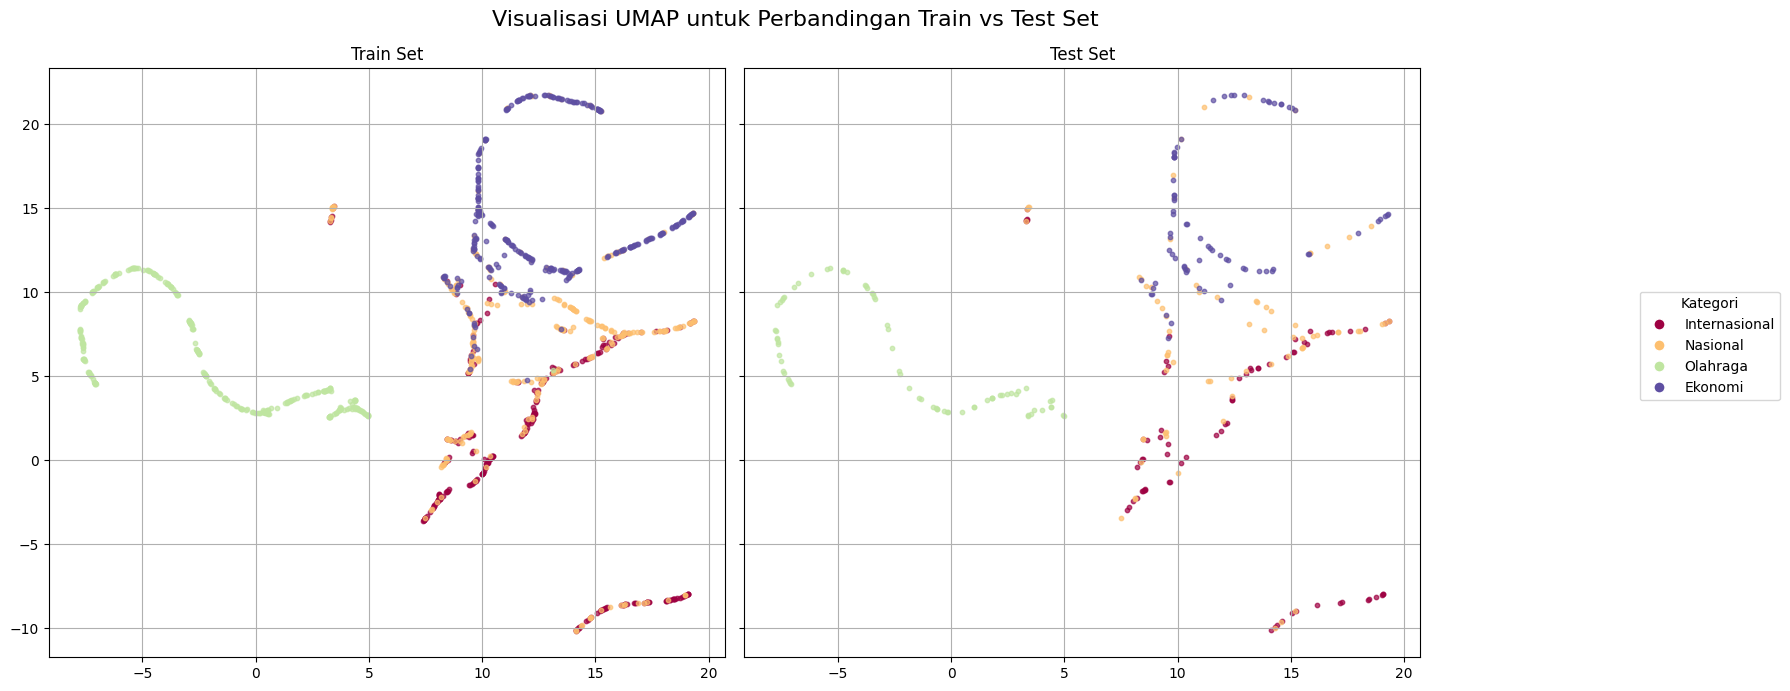


--- Selesai ---


In [6]:
## ANALISIS LANJUTAN DAN VISUALISASI (UMAP)

print("\n--- Membuat visualisasi UMAP untuk perbandingan Train vs Test... ---")

# Siapkan Data untuk Visualisasi 
labels = list(pd.Series(y_train).unique())
label_map = {label: i for i, label in enumerate(labels)}
y_train_numeric = pd.Series(y_train).map(label_map).values
y_test_numeric = pd.Series(y_test).map(label_map).values

# Gabungkan, skalakan, dan terapkan UMAP
X_combined = np.concatenate((X_train, X_test), axis=0)
X_scaled = StandardScaler().fit_transform(X_combined)
reducer = umap.UMAP(n_components=2, random_state=42)
X_2d_combined = reducer.fit_transform(X_scaled)
x2d_train = X_2d_combined[:len(X_train)]
x2d_test = X_2d_combined[len(X_train):]

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)
colors = cm.get_cmap("Spectral", len(labels))

axes[0].set_title("Train Set")
for i, label_name in enumerate(labels):
    axes[0].scatter(x2d_train[y_train_numeric == i, 0], x2d_train[y_train_numeric == i, 1], 
                    color=colors(i / len(labels)), alpha=0.7, s=10)
axes[0].grid(True)

axes[1].set_title("Test Set")
for i, label_name in enumerate(labels):
    axes[1].scatter(x2d_test[y_test_numeric == i, 0], x2d_test[y_test_numeric == i, 1], 
                    color=colors(i / len(labels)), alpha=0.7, s=10)
axes[1].grid(True)

fig.suptitle("Visualisasi UMAP untuk Perbandingan Train vs Test Set", fontsize=16)

# Buat handle legenda secara manual
legend_handles = [Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=colors(i / len(labels)), markersize=8)
                    for i, label in enumerate(labels)]

fig.legend(handles=legend_handles, title="Kategori", loc='center right', bbox_to_anchor=(1.12, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

print("\n--- Selesai ---")